In [85]:
import os

os.chdir(str(globals()["_dh"][0]).removesuffix("/statistics"))
print(os.getcwd())

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import yaml
import numpy as np
import shutil

from Statistics import StatSaver, EpisodeStats
from Config import Config
from scipy.signal import savgol_filter

plt.style.use("seaborn-v0_8")

# Load config file
with open("config.yml", "r") as file:
    global config
    config = Config(yaml.safe_load(file.read()))

loaded_stats: list[EpisodeStats] = StatSaver.load_all_statistics(config.statistics_filename)

# Move to the folder
shutil.rmtree(config.statistics_filename, ignore_errors=True)
os.makedirs(config.statistics_filename, exist_ok=True)
os.chdir(str(os.getcwd() + "/" + config.statistics_filename))
print(os.getcwd())

/home/riccardo/AAS
/home/riccardo/AAS/statistics/QL_F


In [86]:
# Savitzky-Golay and Moving Average window
window_length = 200

In [87]:
num_episodes = len(loaded_stats)

episodes_number = []
episodes_winner = []
episodes_winner_hp_remaining = []

episodes_total_reward = []
episodes_total_actions = []

# For each episode
for episode_stat in loaded_stats:
    # Episode Number
    episodes_number.append(episode_stat.episode_number)

    # Episode Winner
    episodes_winner.append(episode_stat.winner_name)

    # Episode Winner HP
    episodes_winner_hp_remaining.append(episode_stat.winner_hp_remaining)

    total_reward = {}  # agentName, total episode reward
    total_actions = {}  # agentName, dict[actionName, count]

    # For each step
    for agentName, action_taken, reward in episode_stat.step_stats:  # step_stat: (agentName, action_taken, reward)
        # Total reward
        if agentName not in total_reward:  # if agent doesn't exist yet
            total_reward[agentName] = 0
        total_reward[agentName] += reward

        # Total count of actions
        if agentName not in total_actions:  # if agent doesn't exist yet
            total_actions[agentName] = {}

        if action_taken not in total_actions[agentName]:  # if action doesn't exist yet
            total_actions[agentName][action_taken] = 0

        total_actions[agentName][action_taken] += 1

    episodes_total_reward.append(total_reward)
    episodes_total_actions.append(total_actions)

In [88]:
all_actions = sorted(
    set().union(*[actions[agentName].keys() for actions in episodes_total_actions for agentName in actions.keys()])
)
episodes_number_np = np.array(episodes_number).reshape(-1, 1)
num_actions = len(all_actions)

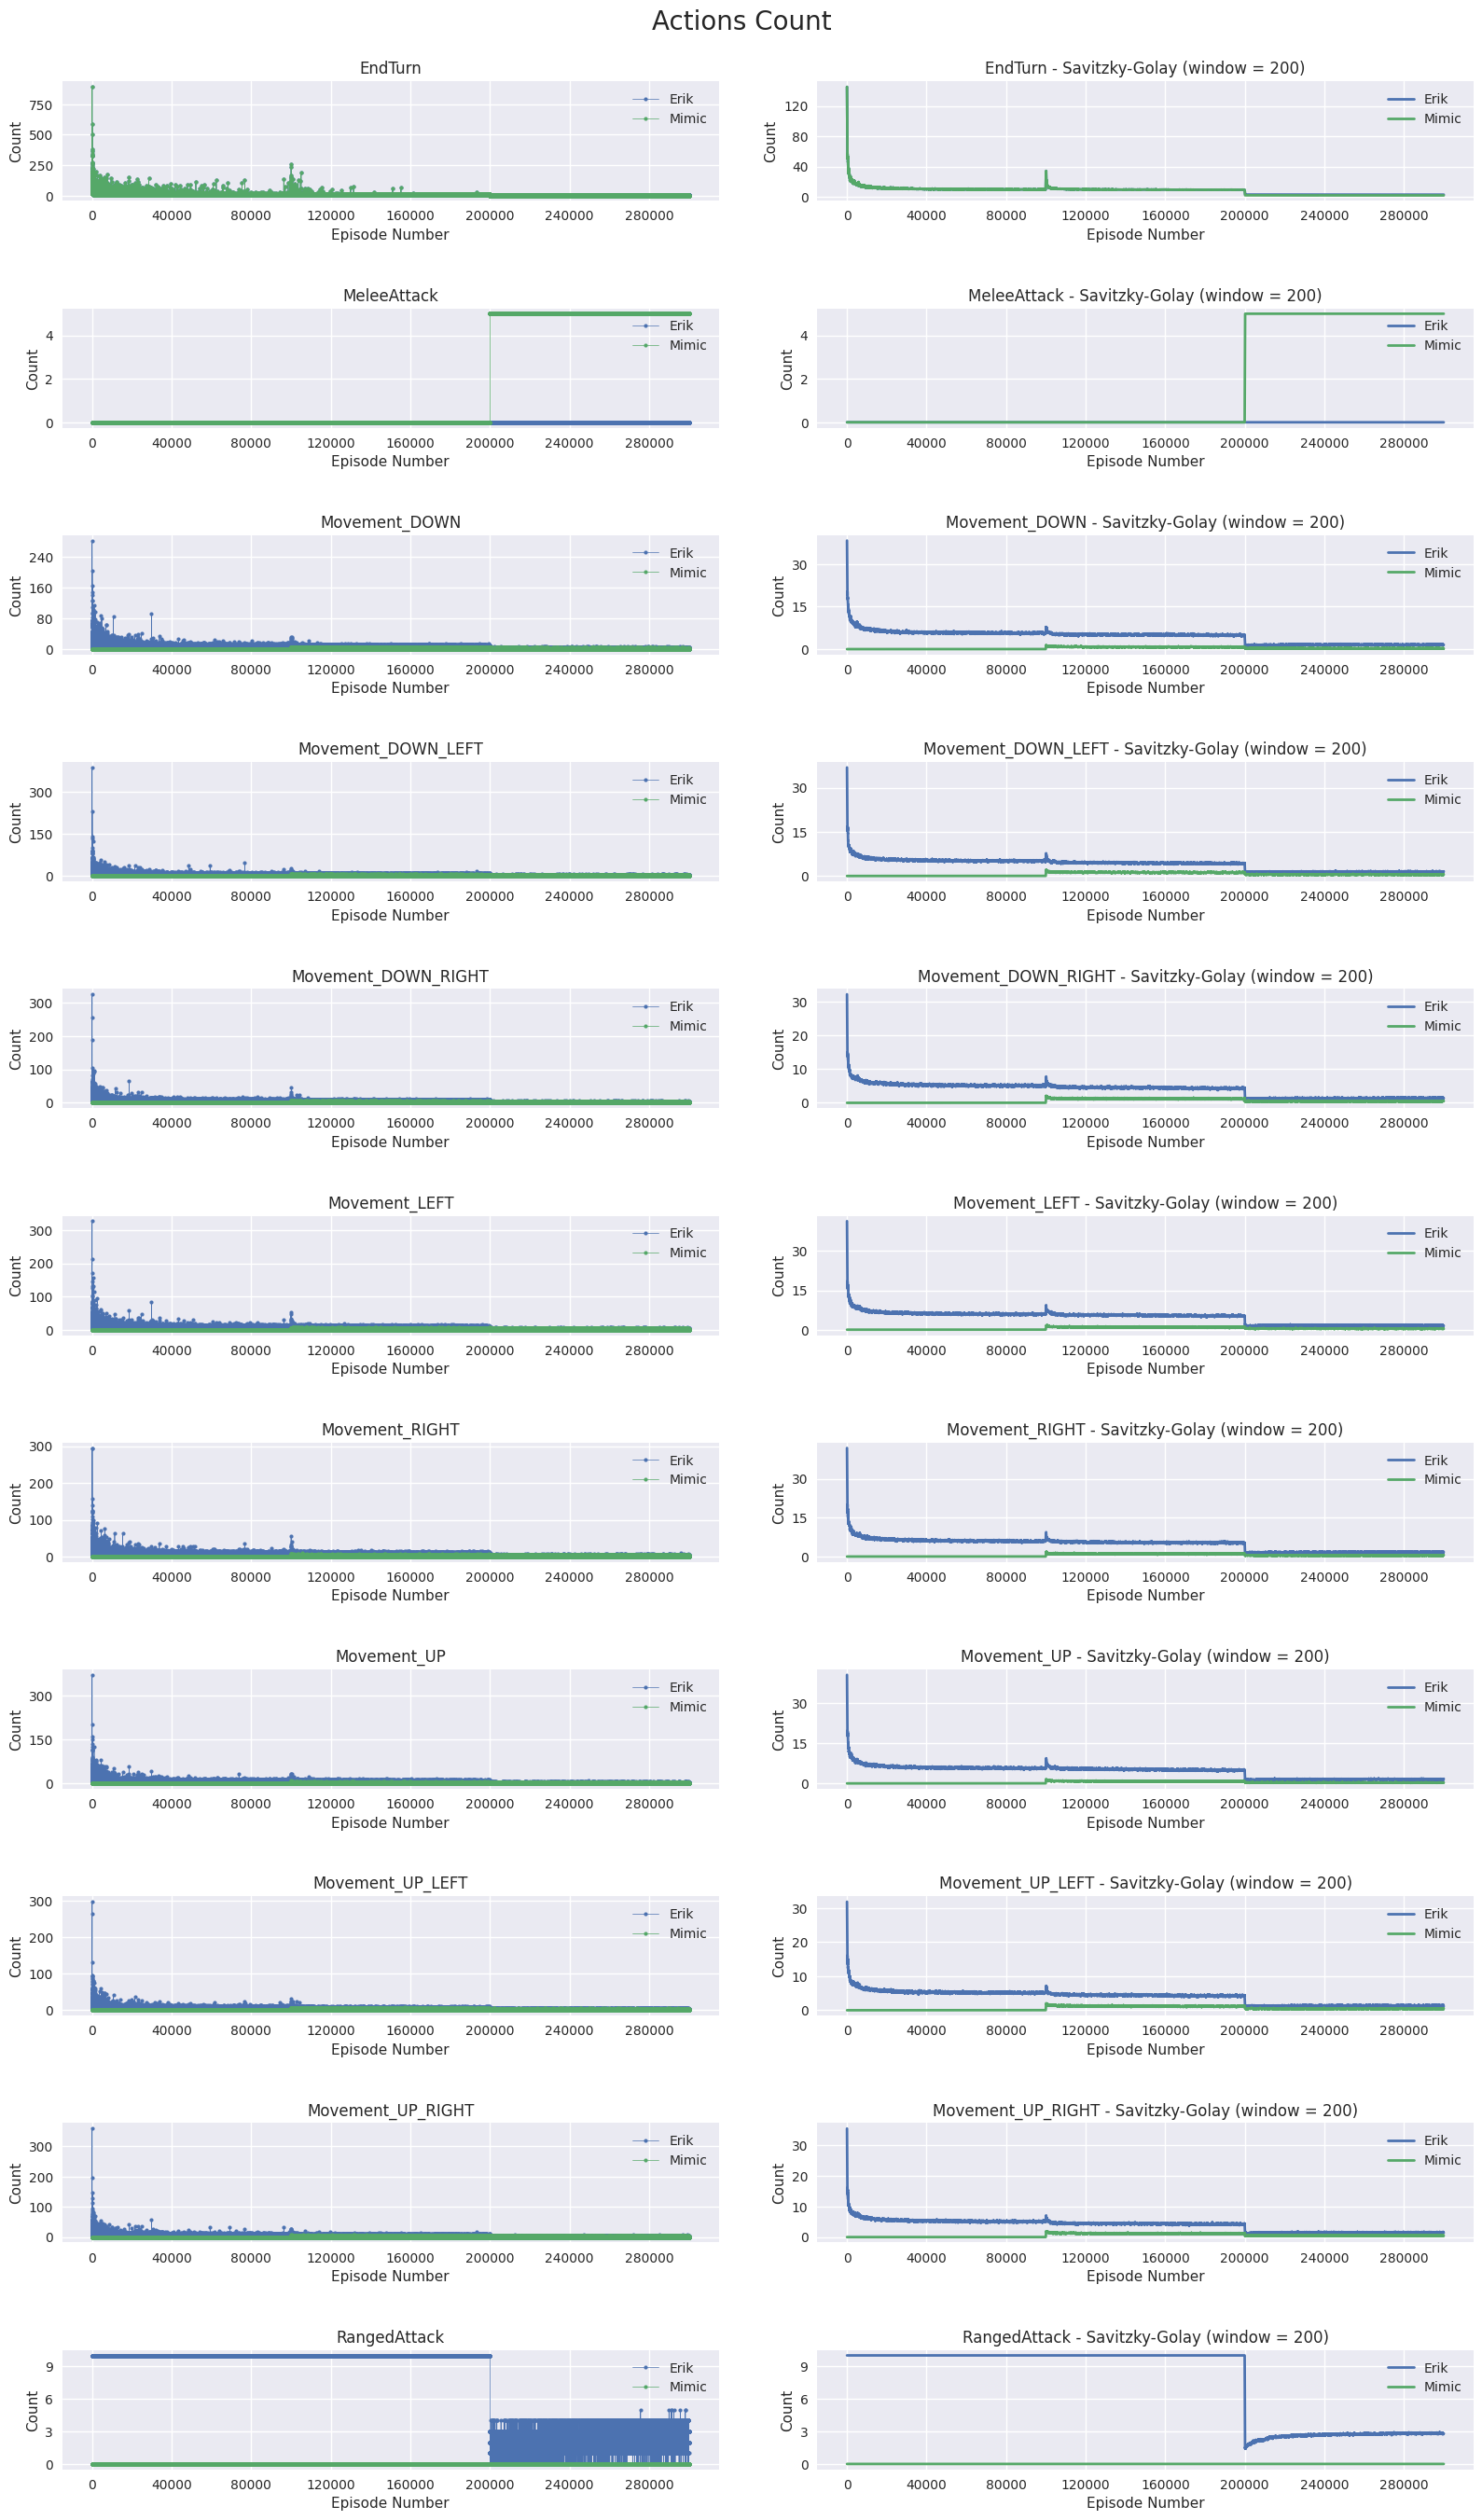

In [89]:
fig, axs = plt.subplots(num_actions, 2, figsize=(16, 27))
axs = axs.ravel()
# For each action
for i, action in enumerate(all_actions):
    # For each agent
    for agentName in episodes_total_actions[0].keys():  # (get agents name from first episode)
        # Entire plot of points
        action_count = [actions[agentName].get(action, 0) for actions in episodes_total_actions]
        axs[2 * i].plot(episodes_number, action_count, "-o", linewidth=0.5, markersize=3, label=agentName)

        # Smoothed data
        smoothed_data = savgol_filter(action_count, window_length, polyorder=1)
        axs[2 * i + 1].plot(episodes_number, smoothed_data, label=f"{agentName}", linewidth=2)

    axs[2 * i].set_title(f"{action}")
    axs[2 * i].set_xlabel("Episode Number")
    axs[2 * i].set_ylabel("Count")
    axs[2 * i].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i].legend(loc="upper right")

    axs[2 * i + 1].set_title(f"{action} - Savitzky-Golay (window = {window_length})")
    axs[2 * i + 1].set_xlabel("Episode Number")
    axs[2 * i + 1].set_ylabel("Count")
    axs[2 * i + 1].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i + 1].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i + 1].legend(loc="upper right")

fig.suptitle("Actions Count", y=0.999, fontsize=20)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.9)
plt.savefig("1.Actions_Count.png", facecolor="white")
plt.show()

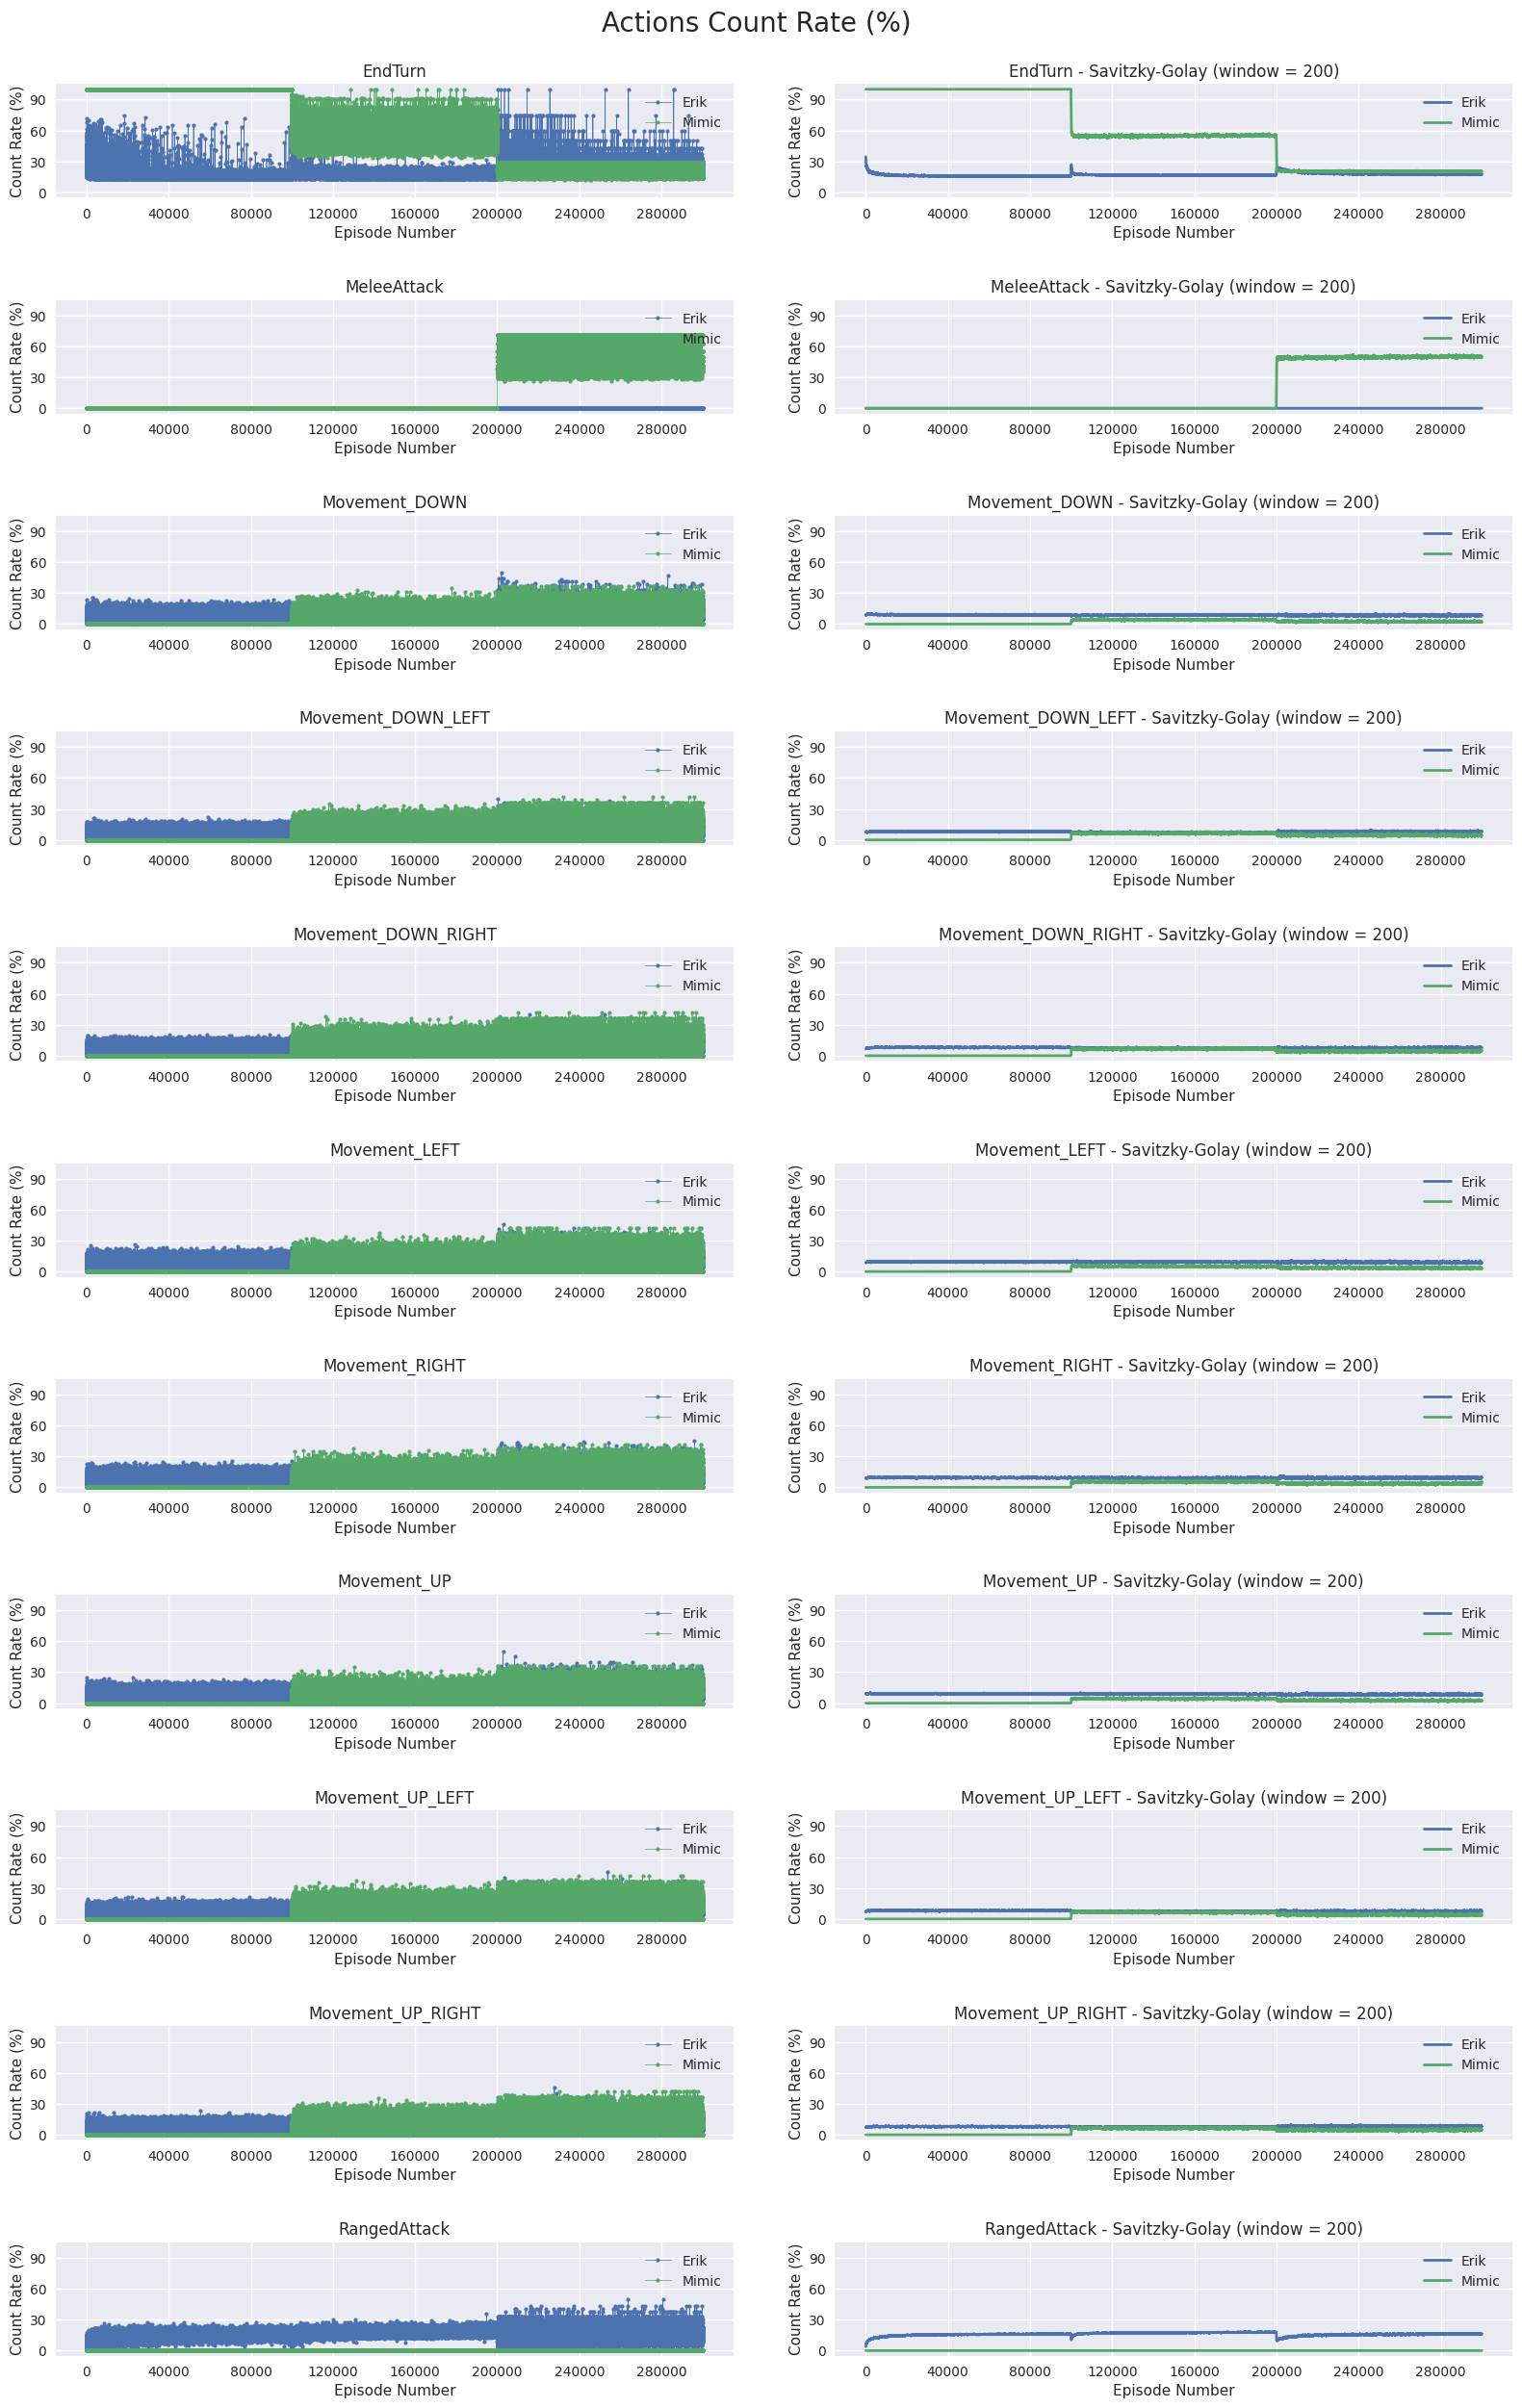

In [90]:
fig, axs = plt.subplots(num_actions, 2, figsize=(16, 25))
axs = axs.ravel()
# For each action
for i, action in enumerate(all_actions):
    # For each agent
    for agentName in episodes_total_actions[0].keys():  # (get agents name from first episode)

        # Get total number of actions taken in each episode by this agent
        total_actions_per_episode = [
            sum(actions[agentName].values()) if agentName in actions else 0 for actions in episodes_total_actions
        ]
        # Number of this action taken in each episode by this agent
        action_count = [
            actions[agentName].get(action, 0) if agentName in actions else 0 for actions in episodes_total_actions
        ]
        # Normalizing
        normalized_action_data = [
            (action_count * 100) / total_actions if total_actions > 0 else 0
            for action_count, total_actions in zip(action_count, total_actions_per_episode)
        ]  # Convert to percentage

        # Entire plot of points
        axs[2 * i].plot(episodes_number, normalized_action_data, "-o", linewidth=0.5, markersize=3, label=agentName)

        # Smoothed data
        smoothed_data = savgol_filter(normalized_action_data, window_length, polyorder=1)
        axs[2 * i + 1].plot(episodes_number, smoothed_data, label=f"{agentName}", linewidth=2)

    axs[2 * i].set_title(f"{action}")
    axs[2 * i].set_xlabel("Episode Number")
    axs[2 * i].set_ylabel("Count Rate (%)")
    axs[2 * i].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i].set_ylim(top=105, bottom=-5)
    axs[2 * i].legend(loc="upper right")

    axs[2 * i + 1].set_title(f"{action} - Savitzky-Golay (window = {window_length})")
    axs[2 * i + 1].set_xlabel("Episode Number")
    axs[2 * i + 1].set_ylabel("Count Rate (%)")
    axs[2 * i + 1].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i + 1].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i + 1].set_ylim(top=105, bottom=-5)
    axs[2 * i + 1].legend(loc="upper right")

fig.suptitle("Actions Count Rate (%)", y=0.999, fontsize=20)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.9)
plt.savefig("2.Actions_Count_Rate.png", facecolor="white")
plt.show()

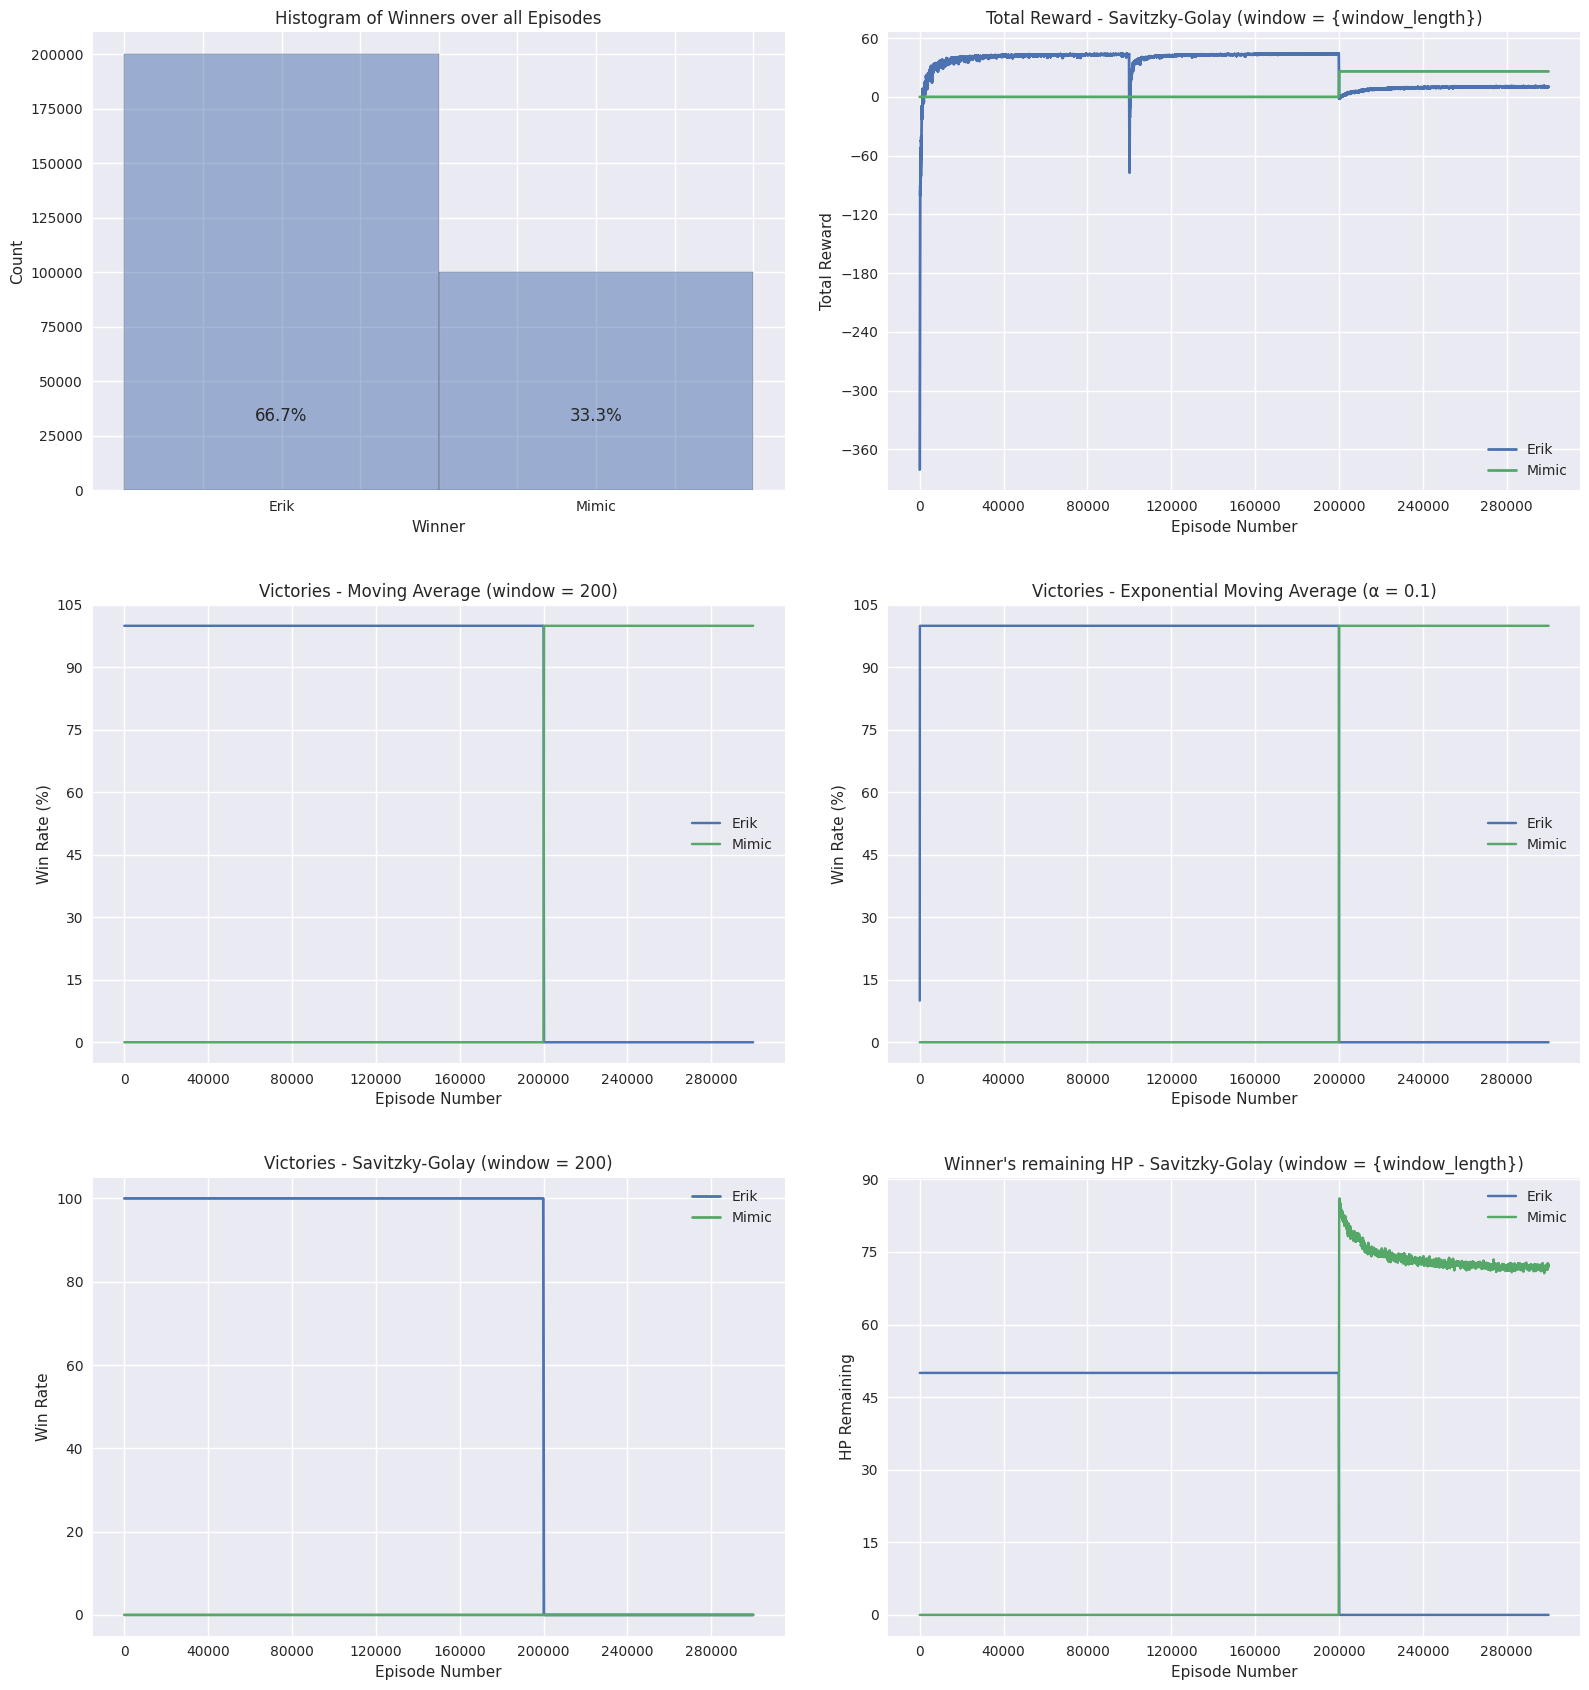

In [91]:
unique_winners = sorted(set(episodes_winner))
winner_numeric = [episodes_winner.index(w) for w in episodes_winner]


def sliding_window_percentage(winners, agent_name, window_size):
    percentages = []
    for i in range(len(winners)):
        start_index = max(0, i - window_size + 1)
        window = winners[start_index : i + 1]
        total = len(window)
        count = window.count(agent_name)
        percentage = (100 * count) / total  # Convert to percentage
        percentages.append(percentage)
    return percentages


def exponential_moving_average(winners, agent_name, alpha):
    ema = []
    current_ema = 0
    for winner in winners:
        reward = 1 if winner == agent_name else 0
        current_ema = alpha * reward + (1 - alpha) * current_ema
        ema.append(current_ema * 100)  # Convert to percentage
    return ema


fig, axs = plt.subplots(3, 2, figsize=(16, 17))
axs = axs.ravel()

# Histogram of winners
counts, bins, patches = axs[0].hist(
    episodes_winner, bins=np.arange(len(unique_winners) + 1) - 0.5, edgecolor="black", alpha=0.5
)
percentages = (counts / counts.sum()) * 100
height = min([h.get_height() for h in patches])
for patch, percentage in zip(patches, percentages):
    axs[0].text(
        patch.get_x() + patch.get_width() / 2, 0.3 * height, f"{percentage:.1f}%", ha="center", va="bottom", fontsize=12
    )
axs[0].set_title("Histogram of Winners over all Episodes")
axs[0].set_xlabel("Winner")
axs[0].set_ylabel("Count")
axs[0].set_xticks(np.arange(len(unique_winners)))
axs[0].set_xticklabels(unique_winners)
axs[0].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[0].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))

# Total Rewards
for agentName in episodes_total_reward[0].keys():
    total_reward_data = [reward[agentName] for reward in episodes_total_reward]

    smoothed_data = savgol_filter(total_reward_data, window_length, polyorder=1)
    axs[1].plot(episodes_number, smoothed_data, label=f"{agentName}", linewidth=2)

axs[1].set_title("Total Reward - Savitzky-Golay (window = {window_length})")
axs[1].set_xlabel("Episode Number")
axs[1].set_ylabel("Total Reward")
axs[1].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[1].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[1].legend()

# Moving Average of Victories
for agent in unique_winners:
    moving_avg = sliding_window_percentage(episodes_winner, agent, window_length)
    axs[2].plot(moving_avg, label=f"{agent}")
axs[2].set_xlabel("Episode Number")
axs[2].set_ylabel("Win Rate (%)")
axs[2].set_title(f"Victories - Moving Average (window = {window_length})")
axs[2].legend()
axs[2].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[2].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[2].set_ylim(top=105, bottom=-5)

# Exponential Moving Average of Victories
alpha = 0.1
for agent in unique_winners:
    ema = exponential_moving_average(episodes_winner, agent, alpha)
    axs[3].plot(episodes_number, ema, label=f"{agent}")
axs[3].set_xlabel("Episode Number")
axs[3].set_ylabel("Win Rate (%)")
axs[3].set_title(f"Victories - Exponential Moving Average (α = {alpha})")
axs[3].legend()
axs[3].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[3].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[3].set_ylim(top=105, bottom=-5)

# Savitzky-Golay smoothed victories for each agent
for idx, agent_name in enumerate(unique_winners):
    agent_wins = np.array([1 if winner == idx else 0 for winner in winner_numeric])
    smoothed_wins = savgol_filter(agent_wins, window_length=window_length, polyorder=1) * 100

    axs[4].plot(episodes_number, smoothed_wins, label=f"{agent_name}", linewidth=2)

axs[4].set_title(f"Victories - Savitzky-Golay (window = {window_length})")
axs[4].set_xlabel("Episode Number")
axs[4].set_ylabel("Win Rate")
axs[4].legend()
axs[4].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[4].set_ylim(top=105, bottom=-5)

# Hp remaining
hp_remaining_dict = {}
for i, winner in enumerate(episodes_winner):
    if winner not in hp_remaining_dict:
        hp_remaining_dict[winner] = [0] * len(episodes_winner)
    hp_remaining_dict[winner][i] = episodes_winner_hp_remaining[i]
for winner, hp_list in hp_remaining_dict.items():
    smoothed_data = savgol_filter(hp_list, window_length=window_length, polyorder=1)
    axs[5].plot(range(len(episodes_winner)), smoothed_data, label=f"{winner}")
axs[5].set_title("Winner's remaining HP - Savitzky-Golay (window = {window_length})")
axs[5].set_xlabel("Episode Number")
axs[5].set_ylabel("HP Remaining")
axs[5].legend()
axs[5].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[5].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.25)
plt.savefig("3.Winners.png", facecolor="white")
plt.show()